## ToBigs 5주차

### Vision Advanced 실습 코드

#### Package Loading

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import VOCSegmentation
import torchvision.models as models
from tqdm import tqdm
import torch.nn.functional as F

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#### UNet 모델 정의

![model_architecture.jpg](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*qNdglJ1ORP3Gq77MmBLhHQ.png)

In [12]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)


class DoubleConv(nn.Module):
    '''(convolution => [BN] => ReLU) * 2'''

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    '''Downscaling with maxpool then double conv'''

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )


    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    '''Upscaling then double conv'''

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)


    def forward(self, x):
        return self.conv(x)

#### Dataset 및 Dataloader 정의  

Dataset은 torchvision 에 존재하는 Pascal VOC Segmentation 데이터를 사용  
기존 데이터는 총 20 개의 클래스를 보유하고 있으나, 학습의 편의성을 위해 이진 분류로 변경  


Pascal VOC 데이터에 대한 자세한 설명은 아래의 link를 참고  
https://bo-10000.tistory.com/38

In [49]:
# 데이터셋 전처리 파이프라인
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

def target_transform_to_binary(target):
    # PIL 이미지를 넘파이 배열로 변환 (RGB로 변환 후 처리)
    target = target.resize((256, 256))
    target = np.expand_dims(np.array(target), axis=0)

    # 0은 배경, 1은 객체로 변환
    # 0 (배경)은 그대로 두고, 0이 아닌 모든 클래스는 1로 설정
    target[target != 0] = 1

    return torch.tensor(target, dtype=torch.float)


train_dataset = VOCSegmentation(
    root='./data',
    year='2012',
    image_set='train',
    download=True,
    transform=transform,  # 이미지에 대한 변환
    target_transform=target_transform_to_binary  # 타겟에 대한 변환
)

val_dataset = VOCSegmentation(
    root='./data',
    year='2012',
    image_set='val',
    download=True,
    transform=transform,
    target_transform=target_transform_to_binary
)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


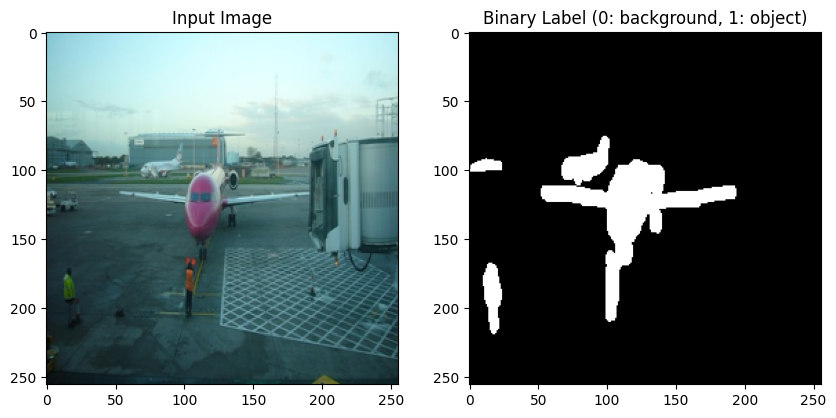

In [51]:
# 이진 분류에 맞춘 흑백 변환 함수
def label_to_binary_color(label):
    # 0은 배경 (검정), 1은 객체 (흰색)
    binary_color = np.where(label == 0, 0, 255)
    return binary_color

# 시각화 함수 (이진 분류에 맞게)
def visualize_sample_binary(dataset, index):
    image, target = dataset[index]

    target = target.squeeze(0).numpy().astype(np.int32)  # 라벨을 넘파이 배열로 변환

    # 이진 분류에 맞춘 라벨을 흑백으로 변환
    target_color = label_to_binary_color(target)

    # 이미지 시각화
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image.permute(1, 2, 0))  # 입력 이미지 출력
    ax[0].set_title('Input Image')

    ax[1].imshow(target_color, cmap='gray')  # 흑백 라벨 출력
    ax[1].set_title('Binary Label (0: background, 1: object)')

    plt.show()

# 시각화 실행
visualize_sample_binary(train_dataset, 0)

In [53]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#### model, loss function, optimizer 정의

model은 앞서 정의한 UNet 을 사용  
loss function은 이진 분류이기에 Binary Cross Entropy with Logits Loss 를 사용  
optimizer는 Adam을 사용하며, learning rate는 0.001 로 설정

In [54]:
# 모델, 손실 함수, 옵티마이저 설정
model = UNet(n_channels=3, n_classes=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [55]:
# 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#### 학습 및 검증 함수 정의

In [56]:
# 학습 및 검증 함수 정의
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, targets in tqdm(loader):
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)  # 타겟의 차원을 맞추기 위해 squeeze
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)
            loss = criterion(outputs, targets)  # 타겟의 차원을 맞추기 위해 squeeze
            running_loss += loss.item()

    return running_loss / len(loader)

#### 학습 및 검증 루프

In [ ]:
# 학습 및 검증 루프
num_epochs = 10
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

#### 모델 예측 결과 확인

In [ ]:
def visualize_prediction(model, dataset, index, device):
    model.eval()  # 모델을 평가 모드로 설정
    image, target = dataset[index]

    # 이미지를 배치로 변경하고 장치로 이동
    image = image.unsqueeze(0).to(device)

    # 모델로 예측 수행
    with torch.no_grad():
        output = model(image)

    # 예측 결과에서 가장 높은 값을 가지는 클래스 선택
    prediction = torch.argmax(output, dim=1).squeeze(0).cpu()

    target = target.squeeze(0)  # 타겟 차원 맞추기

    # 시각화
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(image.squeeze(0).permute(1, 2, 0).cpu())  # 입력 이미지 출력
    ax[0].set_title('Input Image')

    ax[1].imshow(target, cmap='gray')  # 실제 라벨 출력
    ax[1].set_title('True Label')

    ax[2].imshow(prediction, cmap='gray')  # 예측 결과 출력
    ax[2].set_title('Predicted Label')

    plt.show()

# 예시 시각화 (인덱스 0번 샘플을 예측하고 시각화)
visualize_prediction(model, val_dataset, 10, device)


#### 학습 & loss 변화 그래프 확인  
  
학습이 진행됨에 따라 loss가 점점 감소하는 모습을 확인할 수 있음

In [ ]:
import torch
import matplotlib.pyplot as plt

# 손실을 저장할 리스트
train_losses = []
val_losses = []

# 모델을 GPU로 옮기기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 학습 루프 예시
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training phase
    model.train()
    for batch in train_loader:
        inputs, targets = batch

        # 입력 데이터를 모델과 동일한 장치로 옮김 (GPU 또는 CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # 손실값 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase (optional)
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch

            # 검증 단계에서도 입력 데이터를 동일한 장치로 옮김
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # 평균 손실 계산
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # 손실 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# 학습 및 검증 손실 시각화
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Epochs")
    plt.show()

# 손실 시각화 실행
plot_losses(train_losses, val_losses)
